# Find Motifs

Use `stumpy` to identify common motifs in a sequence, and extract them for analysis.

Palin = 8 steps

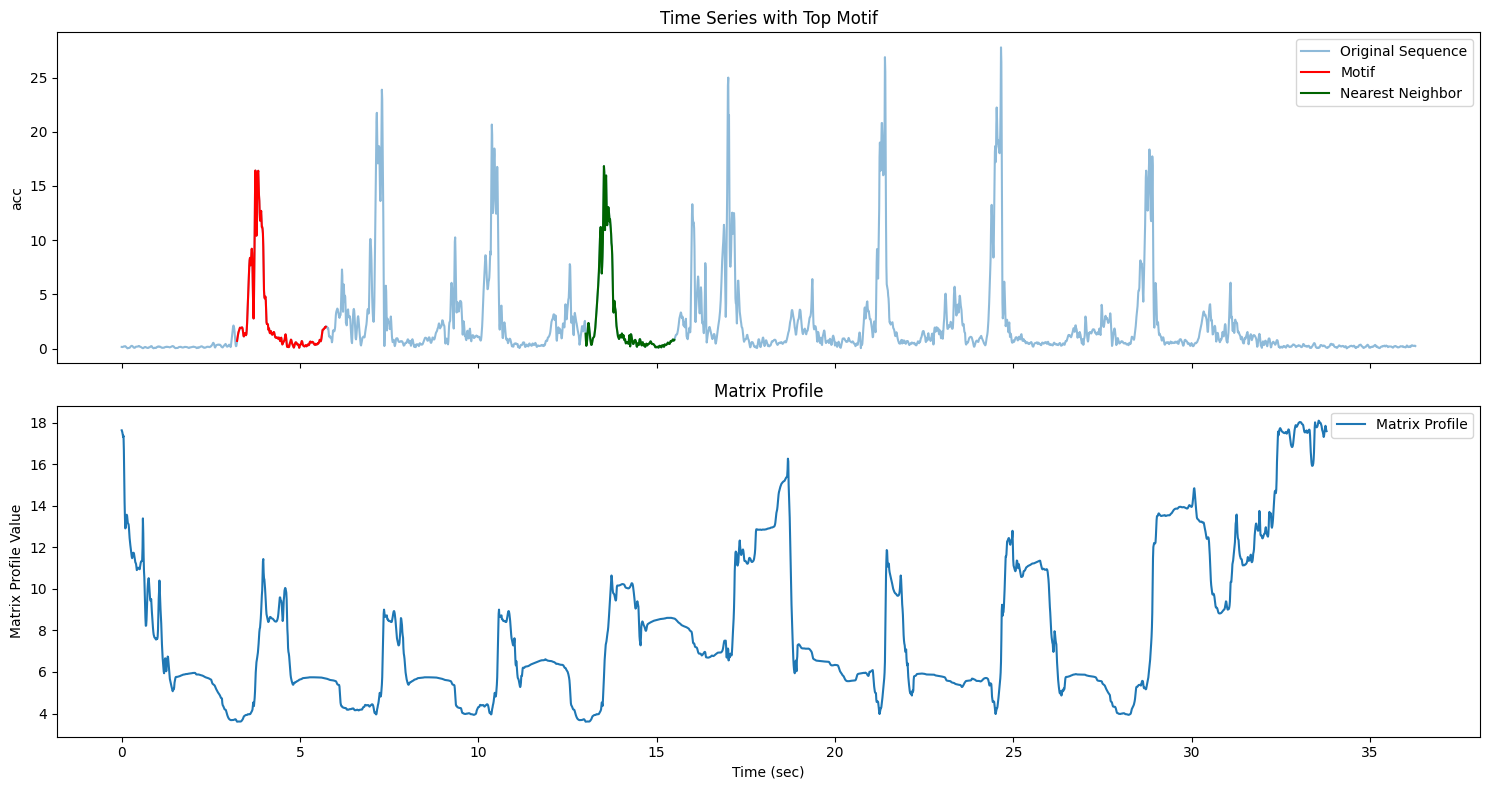

In [1]:
import stumpy
import numpy as np
import pandas as pd
import os
import json

import matplotlib.pyplot as plt

# Read parquet file
data = pd.read_csv('palin_steps.csv')

series_to_analyze = 'acc'
x = data['acc_time']
y = data[series_to_analyze]

# Find motifs using stumpy
pts_per_second = len(x)/np.max(x)
window_size_seconds = 2.5 # chosen to be a "typical" step
window_size = int(window_size_seconds * pts_per_second)
matrix_profile = stumpy.stump(y, m=window_size, normalize=True)

# Find the motif pairs
motif_idx = np.argsort(matrix_profile[:, 0])[0]
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

# Plot the original sequence and the motifs, along with the matrix profile

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Top: Original sequence and motifs
axs[0].plot(x, y, alpha=0.5, label='Original Sequence')
axs[0].plot(x[motif_idx:motif_idx + window_size], 
            y[motif_idx:motif_idx + window_size], 
            c='red', label='Motif')
axs[0].plot(x[nearest_neighbor_idx:nearest_neighbor_idx + window_size], 
            y[nearest_neighbor_idx:nearest_neighbor_idx + window_size], 
            c='darkgreen', label='Nearest Neighbor')
axs[0].legend()
axs[0].set_title('Time Series with Top Motif')
axs[0].set_ylabel(series_to_analyze)

# Bottom: Matrix profile
axs[1].plot(x[:len(matrix_profile)], matrix_profile[:, 0], label='Matrix Profile')
axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel('Matrix Profile Value')
axs[1].set_title('Matrix Profile')
axs[1].legend()

plt.tight_layout()
plt.show()


The not-interesting periods before and after the walking sequence are selected as the strongest motifs.

Let's isolate the dataset to the time we care about by starting at and ending at the first/last times we record an acc of 1.5.

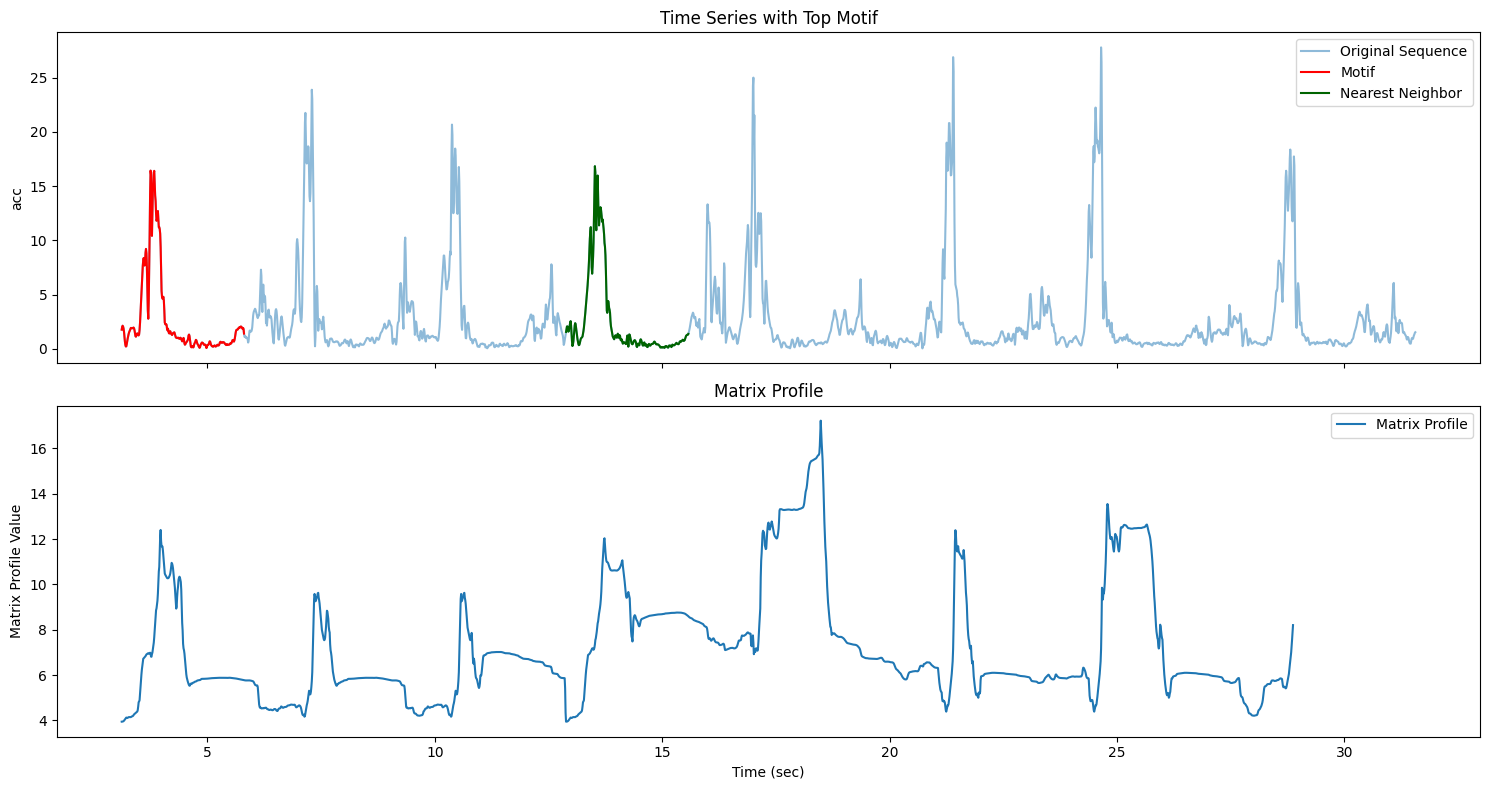

In [2]:
# Read parquet file
data = pd.read_csv('palin_steps.csv')

# Trim the data dataframe to rows between the first and last times the acc is > 1.5
start_idx = data.index[data['acc'] > 1.5][0]
end_idx = data.index[(data['acc'] > 1.5)][-1]
data = data.loc[start_idx:end_idx].reset_index(drop=True)

series_to_analyze = 'acc'
x = data['acc_time']
y = data[series_to_analyze]

# Find motifs using stumpy
pts_per_second = len(x)/np.max(x)
window_size_seconds = 3.0 # chosen to be a "typical" step
window_size = int(window_size_seconds * pts_per_second)
matrix_profile = stumpy.stump(y, m=window_size, normalize=True)

# Find the motif pairs
motif_idx = np.argsort(matrix_profile[:, 0])[0]
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

# Plot the original sequence and the motifs, along with the matrix profile

fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Top: Original sequence and motifs
axs[0].plot(x, y, alpha=0.5, label='Original Sequence')
axs[0].plot(x[motif_idx:motif_idx + window_size], 
            y[motif_idx:motif_idx + window_size], 
            c='red', label='Motif')
axs[0].plot(x[nearest_neighbor_idx:nearest_neighbor_idx + window_size], 
            y[nearest_neighbor_idx:nearest_neighbor_idx + window_size], 
            c='darkgreen', label='Nearest Neighbor')
axs[0].legend()
axs[0].set_title('Time Series with Top Motif')
axs[0].set_ylabel(series_to_analyze)

# Bottom: Matrix profile
axs[1].plot(x[:len(matrix_profile)], matrix_profile[:, 0], label='Matrix Profile')
axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel('Matrix Profile Value')
axs[1].set_title('Matrix Profile')
axs[1].legend()

plt.tight_layout()
plt.show()


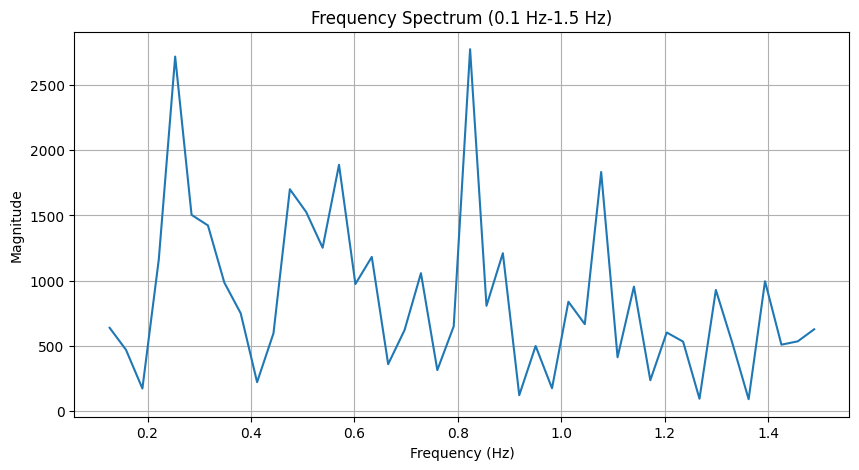

Dominant frequency: 0.82 Hz
Dominant period: 1.21 seconds
Second-place frequency: 0.25 Hz
Second-place period: 3.95


In [5]:
# Perform FFT
sampling_rate = pts_per_second
n = len(y)
fft_result = np.fft.fft(y)
freq = np.fft.fftfreq(n, 1/sampling_rate)

# Get positive frequencies and their magnitudes
positive_freq_mask = freq > 0
positive_freqs = freq[positive_freq_mask]
magnitudes = np.abs(fft_result)[positive_freq_mask]

# Find frequencies in defined range
low_freq_Hz = 0.1
high_freq_Hz = 1.5
freq_range_mask = (positive_freqs >= low_freq_Hz) & (positive_freqs <= high_freq_Hz)
relevant_freqs = positive_freqs[freq_range_mask]
relevant_magnitudes = magnitudes[freq_range_mask]

# Plot the frequency spectrum in the relevant range
plt.figure(figsize=(10, 5))
plt.plot(relevant_freqs, relevant_magnitudes)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title(f'Frequency Spectrum ({low_freq_Hz} Hz-{high_freq_Hz} Hz)')
plt.grid(True)
plt.show()

# Find dominant frequency in this range
dominant_freq_idx = np.argmax(relevant_magnitudes)
dominant_freq = relevant_freqs[dominant_freq_idx]
dominant_period = 1/dominant_freq
print(f"Dominant frequency: {dominant_freq:.2f} Hz")
print(f"Dominant period: {dominant_period:.2f} seconds")

# Find the index of the second-highest magnitude in the relevant range
second_highest_idx = np.argsort(relevant_magnitudes)[-2]
second_highest_freq = relevant_freqs[second_highest_idx]
second_place_period = 1/second_highest_freq
print(f"Second-place frequency: {second_highest_freq:.2f} Hz")
print(f"Second-place period: {second_place_period:.2f}")

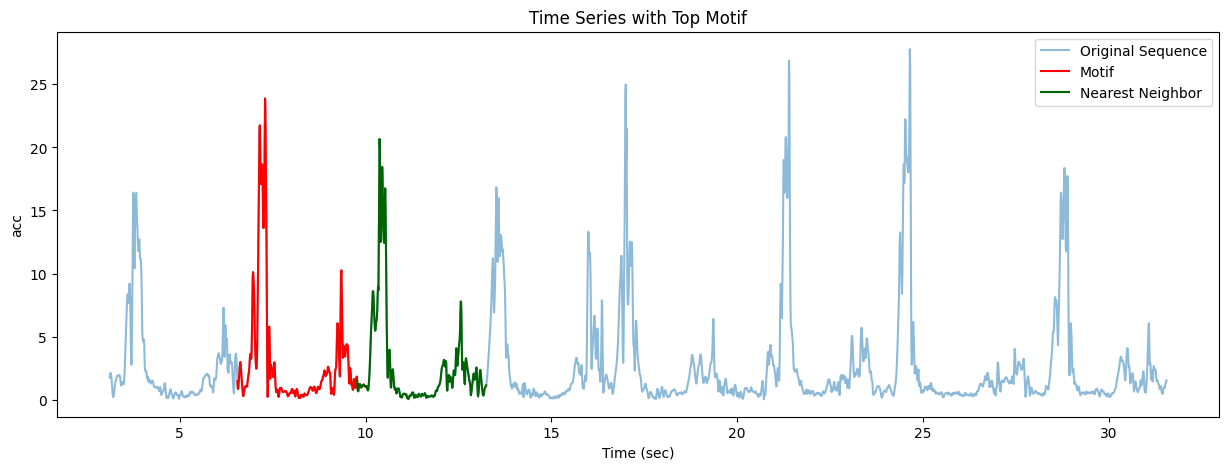

In [6]:
# Use that dominant period as the window size
pts_per_second = len(x)/np.max(x)
window_size_seconds = second_place_period * 0.98
window_size = int(window_size_seconds * pts_per_second)
matrix_profile = stumpy.stump(y, m=window_size)

# Find the motif pairs
motif_idx = np.argsort(matrix_profile[:, 0])[0]
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

# Plot the original sequence and the motifs
plt.figure(figsize=(15, 5))
plt.plot(x,y, alpha=0.5, label='Original Sequence')
plt.plot(x[motif_idx:motif_idx + window_size], 
         y[motif_idx:motif_idx + window_size], 
         c='red', label='Motif')
plt.plot(x[nearest_neighbor_idx:nearest_neighbor_idx + window_size], 
         y[nearest_neighbor_idx:nearest_neighbor_idx + window_size], 
         c='darkgreen', label='Nearest Neighbor')
plt.legend()
plt.title('Time Series with Top Motif')
plt.xlabel('Time (sec)')
plt.ylabel(series_to_analyze)
plt.show()

In [7]:
# Caclulate the top-k matrix profile, then use with the motifs function to find the top-k motifs
matrix_profile = stumpy.stump(y, m=window_size,k=8)

In [8]:
k = 8
motifs = stumpy.motifs(y,np.nanpercentile(matrix_profile[:,0:8],40,axis=1),
                       min_neighbors=1,
                       max_motifs=4,
                       max_matches = 8,
                       )

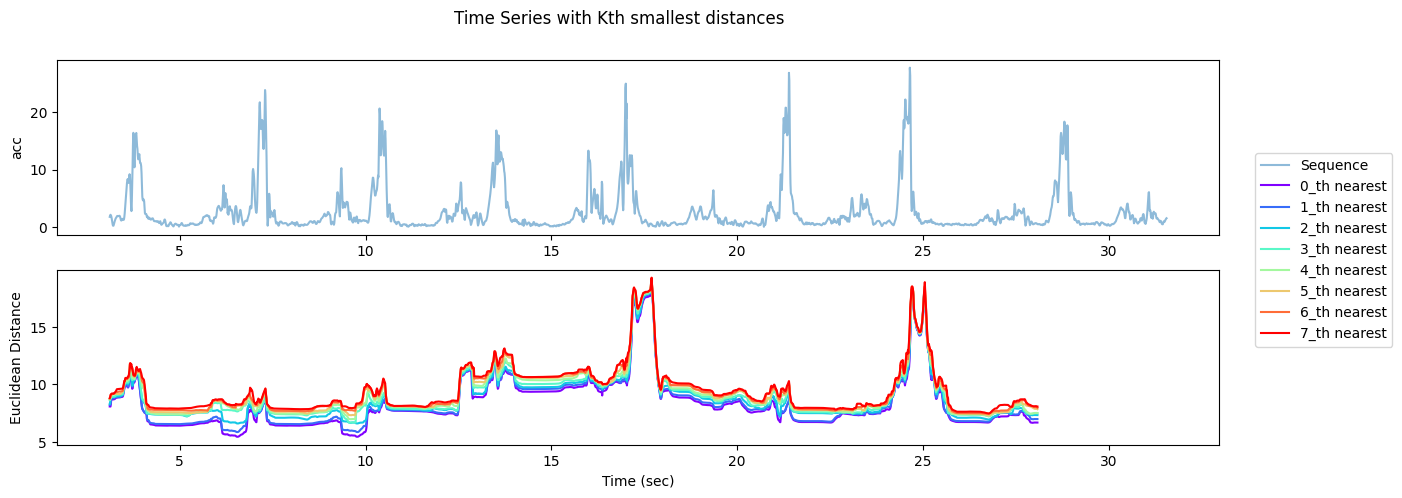

In [9]:
# plot the individual Kth nearest neighbor matrix profiles
#plot the motifs:
fig,ax = plt.subplots(2,)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(x,y, alpha=0.5, label='Original Sequence')
#create a color palatte as long as the seqeunce
colors = plt.cm.rainbow(np.linspace(0, 1, k))
labels = ['Sequence']
for k_idx in range(k):
    color = colors[k_idx]
    ax[1].plot(x[0:-window_size+1], 
         matrix_profile[:,k_idx], 
         label=f'Motif {k_idx}',
         c=color)
    labels.append(f'{k_idx}_th nearest') 

fig.legend(loc='center right', bbox_to_anchor=(1.02, 0.5), labels=labels)

# Adjust layout to make space for the legend
#plt.tight_layout(rect=[0, 0.05, 0.95, 1])  # Leave space on the right for the legend

plt.suptitle('Time Series with Kth smallest distances')
ax[1].set_xlabel('Time (sec)')
ax[0].set_ylabel(series_to_analyze)
ax[1].set_ylabel('Euclidean Distance')
ax[1].set_xlim(ax[0].get_xlim())
plt.show()

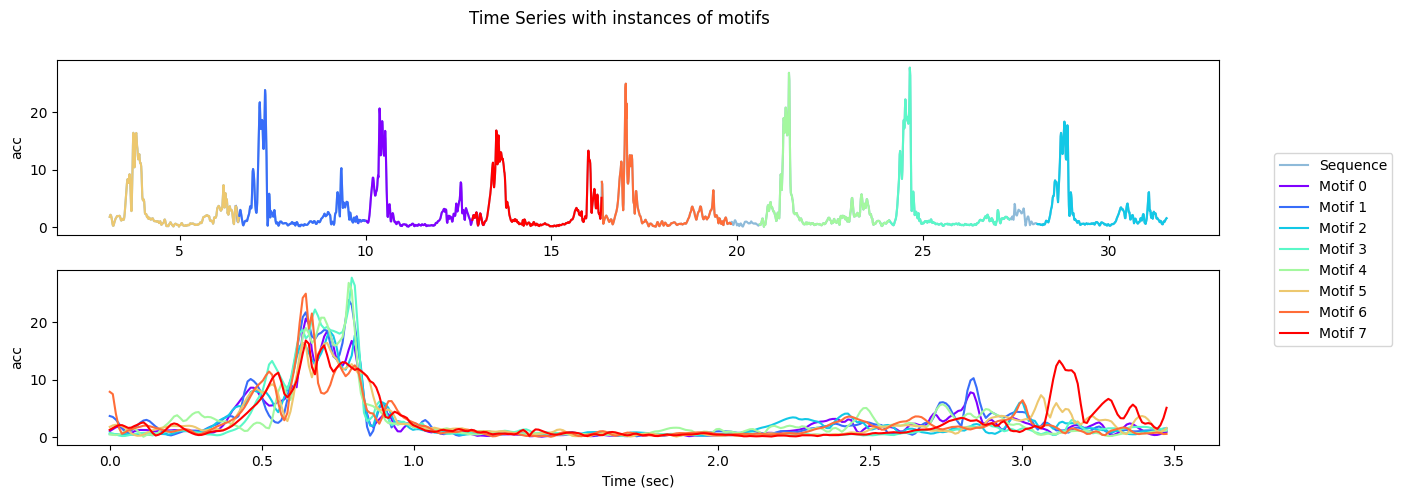

In [10]:
#plot the motifs:
fig,ax = plt.subplots(2,)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(x,y, alpha=0.5, label='Original Sequence')
#create a color palatte as long as the seqeunce
colors = plt.cm.rainbow(np.linspace(0, 1, len(np.ravel(motifs[1]))))
labels = ['Sequence']
for motif_num,idx in enumerate(np.ravel(motifs[1])):
    color = colors[motif_num]
    ax[0].plot(x[idx:idx + window_size], 
         y[idx:idx + window_size], 
         label=f'Motif {motif_num}',
         c=color)
    ax[1].plot(x[idx:idx + window_size] - x[idx], 
         y[idx:idx + window_size], 
         label=f'Motif {motif_num}',
         c=color)
    labels.append(f'Motif {motif_num}') 

fig.legend(loc='center right', bbox_to_anchor=(1.02, 0.5), labels=labels)

# Adjust layout to make space for the legend
#plt.tight_layout(rect=[0, 0.05, 0.95, 1])  # Leave space on the right for the legend

plt.suptitle('Time Series with instances of motifs')
ax[1].set_xlabel('Time (sec)')
ax[0].set_ylabel(series_to_analyze)
ax[1].set_ylabel(series_to_analyze)
plt.show()

In [11]:
# save each motif to its own parquet file with columns t, acc
# since this is a cleese walking sample, save in a subfolder called samples/cleese
# and make the file name reflect the source file and the motif number
os.makedirs('./samples/palin', exist_ok=True)
for motif_num,idx in enumerate(np.ravel(motifs[1])):
    motif_data = data.iloc[idx:idx + window_size]
    motif_data.to_parquet(f'./samples/palin/{series_to_analyze}_{motif_num}.parquet')

In [13]:
# save the data to a file that can be imported to label studio with label forward step for each of the
# identified motifs

os.makedirs('./label_studio', exist_ok=True)

# save a csv copy of the original data
csv_file = './label_studio/palin_data.csv'
data.to_csv(csv_file,index=False)


# save a label-studio JSON file of the pre-annotated data
preannotations = [
  {
    "data": {
        "ts": {
          "acc_time": x.tolist(),
          "acc": y.tolist()
        }
      } 
    ,
    "annotations": [
      {
      "id": 0,
      "result": [
        {
          "value": {
            "start": x[idx],
            "end": x[np.min([idx+window_size,len(x)-1])],
            "instant": False,
            "timeserieslabels": [
              "Palin"
            ]
          },
          "id": f"Motif {motif_num}",
          "from_name": "label",
          "to_name": "ts",
          "type": "timeserieslabels"
        } for motif_num,idx in enumerate(np.ravel(motifs[1]))
      ]
    }
     ]
  }
]
# save JSON to file
json_file = './label_studio/palin_data.json'
with open(json_file, 'w') as f:
    json.dump(preannotations, f)
